## Welcome to Introduction to Named Entity Recognition 🎉

This is our first notebook and will introduce the following topics:

- How to preprocess textual data for NER
- How to implement basic NER pipelines
- How to use the basics of nltk and spacy libraries

***

We've discussed NER at 30000 ft level but how do we actually get a computer to help us take unstructured textual data and recognize named entities?

Well first place to start is with how a computer even matches strings in the first place (sorry if this is repeat info but always good to go over the foundations!).

In [1]:
# Let's import our first libraries for today. We'll be importing more later but first we will be using pandas and Python's regular expression library
import pandas as pd
import re

Today we'll be using two datasets. The first is very tiny and a bit silly, but that's never a bad way to start a workshop!

The dataset is a collection of movie scripts and metadata for the first three Harry Potter films (available publicly here on Kaggle https://www.kaggle.com/gulsahdemiryurek/harry-potter-dataset and apparently scraped from the potter wiki and pottermore.com).

I usually teach NER using a web scraped version of the Humanist Listserv, but since I used it last week, I decided to mix it up a bit and William Mattingly uses a similar dataset in his videos on NER and DH, which I highly recommend and you can find them here https://pythonhumanities.com/.

In [2]:
# Let's load in and inspect our data starting with the Characters spreadsheet
chars_df = pd.read_csv('./archive/Characters.csv', delimiter=';')
chars_df[0:1]

,Id,Name,Gender,Job,House,Wand,Patronus,Species,Blood status,Hair colour,Eye colour,Loyalty,Skills,Birth,Death
0,1,Harry James Potter,Male,Student,Gryffindor,"11"" Holly phoenix feather",Stag,Human,Half-blood,Black,Bright green,Albus Dumbledore | Dumbledore's Army | Order o...,Parseltongue| Defence Against the Dark Arts | ...,31 July 1980,NaN


In [3]:
# Let's also load in the first film script
film1_df = pd.read_csv('./archive/Harry Potter 1.csv', delimiter=';')
film1_df[0:1]

,Character,Sentence
0,Dumbledore,"I should've known that you would be here, Prof..."


Now looking at these two files, you can immediately see that `chars_df` holds our metadata, whereas `film1_df` holds two columns representing the character speaking and their speech.

So why would NER be helpful for extracting information from this dataset?

![](https://newleftreview.org/system/dragonfly/production/2019/05/13/4k9ql9wxyf_3020501large.gif)

This figure is from Stanford's Literary Lab Pamphlet exploring network analysis of Hamlet's plot. You can read more about the experiment here https://litlab.stanford.edu/LiteraryLabPamphlet2.pdf or read a similar network analysis here by James Lee https://dasil.sites.grinnell.edu/2014/11/a-network-analysis-of-shakespeares-plays/

But essentially we can use NER to help us extract when a character speaks the name of another character. So let's try it out!

First, let's start by browsing the documentation on string manipulation with Pandas https://pandas.pydata.org/pandas-docs/stable/user_guide/text.html. 

(If you need a more in-depth refresher checkout Melanie Walsh's notebooks from the earlier workshop on Data Analysis with Pandas https://github.com/melaniewalsh/Data-Analysis-with-Pandas).

In [4]:
# How might we do string matching based on pandas docs?
film1_df[film1_df.Sentence.str.contains(chars_df[0:1].Name.values[0])]

,Character,Sentence


Why didn't the above code work? Should we try a different method? Or is something wrong with the underlying data 🤔?

In [5]:
# #  Let's inspect chars_df
chars_df[0:1].Name.values[0]

'Harry James Potter'

We can solve this issue a few ways, let's start with splitting names apart so we can search for first and last names separately.

In [6]:
chars_df['split_names'] = chars_df.Name.str.split(' ')

film1_df[film1_df.Sentence.str.contains('|'.join(chars_df[0:1].split_names.values[0]))]

,Character,Sentence
28,Dumbledore,Good luck...Harry Potter.
107,Dudley,"Dad, look! Harry's got a letter!"
117,Vernon,"Right you are, Harry!"
133,Harry,"Make a wish, Harry."
139,Hagrid,"Mind, I haven't seen you since you was a baby,..."
...,...,...
1536,Dumbledore,"Harry, do you know why Professor Quirrell coul..."
1542,Dumbledore,"Love, Harry, love."
1565,Dumbledore,"And third, to Mr. Harry Potter, for pure nerve..."
1576,Hermione,"Come on, Harry."


Great we're getting results! I realize the syntax is a little wonky but essentially we're splitting names and them joining them back together with the pipe operator so that pandas knows to check for any of them within the sentence (so in this case `Harry`, `James`, or `Potter` exists in 114 rows).

Let's try and get this code working with all our character names.

In [7]:
def find_entities(row):
    character_names = chars_df.split_names.tolist()
    identified_names = []
    for names in character_names:
        if any(name in row.Sentence for name in names):
            identified_names.append(' '.join(names))
    row['identified_names'] = identified_names
    return row
film1_entities = film1_df.apply(find_entities, axis=1)

In [8]:
# Let's inspect our results
film1_entities.head()

,Character,Sentence,identified_names
0,Dumbledore,"I should've known that you would be here, Prof...",[Minerva McGonagall]
1,McGonagall,"Good evening, Professor Dumbledore.","[Albus Percival Wulfric Brian Dumbledore, Aber..."
2,McGonagall,"Are the rumors true, Albus?","[Albus Percival Wulfric Brian Dumbledore, Albu..."
3,Dumbledore,"I'm afraid so, professor.",[]
4,Dumbledore,The good and the bad.,[]


In [9]:
film1_entities = film1_entities[film1_entities.identified_names.astype(bool)]
film1_exploded = film1_entities.explode('identified_names')
film1_exploded.head()

,Character,Sentence,identified_names
0,Dumbledore,"I should've known that you would be here, Prof...",Minerva McGonagall
1,McGonagall,"Good evening, Professor Dumbledore.",Albus Percival Wulfric Brian Dumbledore
1,McGonagall,"Good evening, Professor Dumbledore.",Aberforth Dumbledore
2,McGonagall,"Are the rumors true, Albus?",Albus Percival Wulfric Brian Dumbledore
2,McGonagall,"Are the rumors true, Albus?",Albus Severus Potter


This looks pretty close to what we want. We might eventually try and reconcile the names in `Character` and `identified_names`, but we've know officially run our first NER algorithm 🎉.

But wait... let's inspect a little closer 🤔

In [10]:
film1_exploded[film1_exploded.Sentence.str.contains('James')]

,Character,Sentence,identified_names
188,Hagrid,A car crash killed Lily and James Potter?,Harry James Potter
188,Hagrid,A car crash killed Lily and James Potter?,Lily J. Potter
188,Hagrid,A car crash killed Lily and James Potter?,James Potter
188,Hagrid,A car crash killed Lily and James Potter?,Albus Severus Potter
188,Hagrid,A car crash killed Lily and James Potter?,James Sirius Potter


We can see in this example that while we are correctly identifying Lily and James Potter, we're also returning values for Harry and Albus Potter. This makes sense since we're only checking if **any** of the strings in the names match. If we try to match the whole exact name we end up back we're we started, since few characters say the full name of the character they are either speaking  or referring to.

There's a few solutions we could implement.

We could for example try and remove middle names since they are used infrequently and we could even write a function that uses distance metrics to weight our matches. 

But instead of going deeper here let's zoom out for a second.

***

#### Pre-Processing and Interpretation

So far we've used a list of characters metadata, separated the names by spaces, and then checked if those names matched, which gave us some preliminary data but still some errors as well.

All of these steps might feel small, but they actually represent big interpretative choices. 

While these types of choices are often called *data cleaning* or *pre-processing*, they are all influential because each choice means we are altering our underlying dataset to prioritize algorithmic tractability.

In "Evaluating the Stability of Embedding-based Word Similarities", Maria Antoniak and David Mimno describe the differing research goals of those interested in using NLP methods for *downstream-centered* versus *corpus-centered* research. 

![](./images/corpus_downstream.png)

I often find this distinction is an important one to reinforce because for many tutorials and resources available, they assume that we are interested in downstream (that is we are using NLP methods and a corpus to either optimize our method or develop some downstream application like a search engine). However, most humanists are actually corpus-centric. We care about our data and representing it as accurately as possible, which means every pre-processing step needs to be considered carefully. So let's discuss some of these choices.

##### Tokenization

In the field of corpus linguistics, the term “word” is generally dispensed with as too abstract in favor of the idea of a “token” or “type.” Breaking a piece of text into words is thus called “tokenization.”

![tokenize](https://blog.floydhub.com/content/images/2020/02/tokenize.png)

While so far we've tokenized on spaces, this image shows that we could do punctuation or even our set of rules depending on our goals and also our language of interest. Here's a deeper dive into other forms of tokenization for those interested https://blog.floydhub.com/tokenization-nlp/.

In our example above, instead of tokenizing the names into unigrams, we might have tried bigrams instead to make sure we were catching full names as well.

##### Lemmatizing and Stemming 

In addition to tokenization, the other big choice we'll be making with NER is if we want to employ lemmatizing or stemming to our text to help identify entities and also limit the number of potential similar options. 

![stemming](https://miro.medium.com/max/1400/1*-MTbZK9ha3Kp1Z50o79Tzg.png)

![lemma](https://devopedia.org/images/article/227/6785.1570815200.png)

These choices will help normalize our data, which might work well if we're dealing with either OCR or human-entered data (both of which are notoriously error prone).

Here is some code for actually implementing both stemming and lemmatizing.

```python
from nltk.stem import PorterStemmer
porter = PorterStemmer()
```
First import the Porter Stemmer from NLTK, which is one of the more common stemming approaches. We can try out the stemmer using the `stem()` method on our text and then test if it is equal to the initial `text`.
```python
stemmed = porter.stem(text)
print(stemmed == text)
```
We can test it out on our text, but really we want to use it on each row, so let's create a new function called `stem_words`.
```python
def stem_words(row):
    stemmed_words = ''
    for token in row.split(' '):
        stemmed_words += porter.stem(token) + ' '
    return stemmed_words
film1_df['stemmed_sentence'] = film1_df.Sentence.apply(stem_words)
```

We can also import the `WordNetLemmatizer` from NLTK to also test out lemmatizing our text, and then create a second function to lemmatize the text.

```python
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
wordnet_lemmatizer = WordNetLemmatizer()

def lemma_words(row):
    lemmatized_words = ''
    for token in row.split(' '):
        lemmatized_words += wordnet_lemmatizer.lemmatize(token) + ' '
    return lemmatized_words
film1_df['lemmatized_sentence'] = film1_df.Sentence.apply(lemma_words)
```


Another option is to use more complex string matching. For example, there's a popular Python library called `Fuzzy Wuzzy` that uses levenshtein distance to calculate string matches https://github.com/seatgeek/fuzzywuzzy.

![fuzzywuzzy](./images/fuzzywuzzy.png)

Or we might try the library `Textpack` that uses TFIDF weighting to also help normalize data across columns https://github.com/lukewhyte/textpack.

![textpack](./images/textpack.png)

One final thing we could do to normalize our data is try lowercasing both the character names and our film data to maximize matches (especially since we didn't actually scrape this data ourselves and so there might be inconsistencies or we might even be working with languages where there is no captialization).

In [11]:
film1_exploded['sentence_lower'] = film1_exploded.Sentence.str.lower()
chars_df['name_lower'] = chars_df.Name.str.lower()

At this stage we could re-run our code, but one thing to think about is whether lowercasing our strings is not only going to get us more matches, but also more errors.

For example, the name `Potter` might refer to at least three characters, but it is also both a verb and noun in English. 

***
#### The Challenges of Unstructured Text

The example above highlights one of the struggles of working with unstructured textual data and NER - that is many meanings of words are contextual.  

Our example of `Potter` is an instance of *polysemy* - that is a word that has multiple, related meanings (another great example is the word `book`).

We also have the issue of *homonymy*, when words are spelt the same but have completely distinct meanings (think of words like `bat` or `bank`).

Finally we have *metonymy* where words are replaced with another reference but have the same meaning. A common example is businessman with suits, but in our dataset probably the best example is Voldemort with He-Who-Must-Not-Be-Named.

NLP has developed lots of approaches for dealing with these issues (think of our slide listing NLP and NLU for example), but let's focus on seeing how NER can help us tackle these issues.

#### NER Python Libraries

There are multiple libraries for NER in Python, and evaluating which one is right for your project and data depends on a few different factors. Each of these libraries has its own history, and some of what they provide overlaps. Here's a helpful chart outlining some of their pros and cons.

![comparison](https://activewizards.com/content/blog/Comparison_of_Python_NLP_libraries/nlp-librares-python-prs-and-cons01.png)

The main ones for NER particularly are the following:

- NLTK [https://www.nltk.org/](https://www.nltk.org/)

- spaCy [https://spacy.io/](https://spacy.io/)

- STANZA https://stanfordnlp.github.io/stanza/

- SPARK NLP https://www.johnsnowlabs.com/spark-nlp/


I was initially planning to start with NLTK since it was largely the original (started in 2001), but I was having some dependency errors for their NER module (`ne_chunk`). So if you want to try it out yourself feel free to check out the instructions in the NLTK book https://www.nltk.org/book/ch07.html (look for 5   Named Entity Recognition
).

Instead, let's start off with spaCy!


In [12]:
# # Download Spacy in Binder
# !pip install -U pip setuptools wheel
# !pip install -U spacy
# !python -m spacy download en_core_web_sm

In [13]:
# # Download Spacy if running locally
# import sys
# !{sys.executable} -m pip install spacy
# !{sys.executable} -m spacy download en_core_web_sm

We then need to download a model to work with spaCy so let's take a look at the model options and documentation https://spacy.io/usage/models

In [14]:
# Finally we can import Spacy and the model
import spacy
nlp = spacy.load('en_core_web_sm')
# Or use the default model, which has fewer features:
# nlp = spacy.load('en')

Let's take a look at the spaCy implementation https://spacy.io/usage/spacy-101#annotations-ner

In [15]:
doc = nlp("Apple is looking at buying U.K. startup for $1 billion")

for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

Apple 0 5 ORG
U.K. 27 31 GPE
$1 billion 44 54 MONEY


In [16]:
type(doc), doc

(spacy.tokens.doc.Doc, Apple is looking at buying U.K. startup for $1 billion)

What is a type `Doc`? [https://spacy.io/api/doc](https://spacy.io/api/doc)

In [17]:
# Let's dig into what this Class gives us
[prop for prop in dir(doc) if not prop.startswith('_')]

['cats',
 'char_span',
 'copy',
 'count_by',
 'doc',
 'ents',
 'extend_tensor',
 'from_array',
 'from_bytes',
 'from_dict',
 'from_disk',
 'from_docs',
 'get_extension',
 'get_lca_matrix',
 'has_annotation',
 'has_extension',
 'has_unknown_spaces',
 'has_vector',
 'is_nered',
 'is_parsed',
 'is_sentenced',
 'is_tagged',
 'lang',
 'lang_',
 'mem',
 'noun_chunks',
 'noun_chunks_iterator',
 'remove_extension',
 'retokenize',
 'sentiment',
 'sents',
 'set_ents',
 'set_extension',
 'similarity',
 'spans',
 'tensor',
 'text',
 'text_with_ws',
 'to_array',
 'to_bytes',
 'to_dict',
 'to_disk',
 'to_json',
 'to_utf8_array',
 'user_data',
 'user_hooks',
 'user_span_hooks',
 'user_token_hooks',
 'vector',
 'vector_norm',
 'vocab']

We also have the Class `Token` [https://spacy.io/api/token](https://spacy.io/api/token)

In [18]:
first_word = doc[0]
type(first_word)

spacy.tokens.token.Token

In [19]:
[prop for prop in dir(first_word) if not prop.startswith('__')]

['_',
 'ancestors',
 'check_flag',
 'children',
 'cluster',
 'conjuncts',
 'dep',
 'dep_',
 'doc',
 'ent_id',
 'ent_id_',
 'ent_iob',
 'ent_iob_',
 'ent_kb_id',
 'ent_kb_id_',
 'ent_type',
 'ent_type_',
 'get_extension',
 'has_dep',
 'has_extension',
 'has_head',
 'has_morph',
 'has_vector',
 'head',
 'i',
 'idx',
 'iob_strings',
 'is_alpha',
 'is_ancestor',
 'is_ascii',
 'is_bracket',
 'is_currency',
 'is_digit',
 'is_left_punct',
 'is_lower',
 'is_oov',
 'is_punct',
 'is_quote',
 'is_right_punct',
 'is_sent_end',
 'is_sent_start',
 'is_space',
 'is_stop',
 'is_title',
 'is_upper',
 'lang',
 'lang_',
 'left_edge',
 'lefts',
 'lemma',
 'lemma_',
 'lex',
 'lex_id',
 'like_email',
 'like_num',
 'like_url',
 'lower',
 'lower_',
 'morph',
 'n_lefts',
 'n_rights',
 'nbor',
 'norm',
 'norm_',
 'orth',
 'orth_',
 'pos',
 'pos_',
 'prefix',
 'prefix_',
 'prob',
 'rank',
 'remove_extension',
 'right_edge',
 'rights',
 'sent',
 'sent_start',
 'sentiment',
 'set_extension',
 'set_morph',
 'shape'

So let's try this out with our data!

In [20]:
film1_doc = nlp(film1_df[0:1].Sentence.values[0])
film1_doc

I should've known that you would be here, Professor McGonagall.

In [21]:
# We could use spaCy for parts-of-speech tagging of this sentence
for token in film1_doc:
    print(token.text, token.pos_)

I PRON
should AUX
've AUX
known VERB
that SCONJ
you PRON
would AUX
be VERB
here ADV
, PUNCT
Professor PROPN
McGonagall PROPN
. PUNCT


In [22]:
from spacy import displacy
displacy.render(film1_doc, style="dep")

In [23]:
from spacy import displacy
displacy.render(film1_doc, style="ent")

/Users/EZCorp/workspace/tapi_workshops/ner_hum/ner_hum_env/lib/python3.9/site-packages/spacy/displacy/__init__.py:189: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


In [24]:
london_doc = nlp(film1_df[film1_df.Sentence.str.contains('London')][1:2].Sentence.values[0])
london_doc


He received an urgent owl from the Ministry of Magic and left immediately for London.

In [25]:
displacy.render(london_doc, style="ent")

![spacy_entities](https://devopedia.org/images/article/256/8660.1580659054.png)

In [26]:
# So let's try and write a function to identify all Named Entities in our script

def find_spacy_entities(row):
    # code goes here
    spacy_sentence = nlp(row.Sentence)
    
    list_tokens = []
    list_entities = []
    for token in spacy_sentence.ents:
        list_tokens.append(token.text)
        list_entities.append(token.label_)
    row['spacy_tokens'] = list_tokens
    row['spacy_entities'] = list_entities
    return row

film1_df = film1_df.apply(find_spacy_entities, axis=1)

In [27]:
film1_df.head()

,Character,Sentence,spacy_tokens,spacy_entities
0,Dumbledore,"I should've known that you would be here, Prof...",[],[]
1,McGonagall,"Good evening, Professor Dumbledore.","[evening, Dumbledore]","[TIME, PERSON]"
2,McGonagall,"Are the rumors true, Albus?",[Albus],[GPE]
3,Dumbledore,"I'm afraid so, professor.",[],[]
4,Dumbledore,The good and the bad.,[],[]


#### Rules-Based NER and Gazetteers

So let's compare spaCy to what we had originally. You can see that spaCy is identifying for more entities than we did with the characters which might be useful depending on our goals, but for our network example we want the characters not just any entities.

One way to think of our characters metadata is as a gazetteer.

Gazetteers are a popular method in DH of dealing with variation in NER and identifying historical entities. You can look at the World Historical Gazetteer as an example http://whgazetteer.org/.

With our characters list as a gazetteer, we could just keep trying to write more and more complex for loops, but alternatively we could join spaCy with this gazetteer by adding in new rules to our model.

In [28]:
#Create the EntityRuler
ruler = nlp.add_pipe("entity_ruler")
patterns = [
    {"label": "PERSON", "pattern": "McGonagall"}
]
ruler.add_patterns(patterns)


In [29]:
doc = nlp(film1_df[0:1].Sentence.values[0])
#extract entities
for ent in doc.ents:
    print (ent.text, ent.label_)

McGonagall PERSON


We can read more about rules based NER in William's textbook http://ner.pythonhumanities.com/02_rules_based_ner.html and the spacy documentation https://spacy.io/api/entityruler but for now let's try together to add in our remaining characters and see if we can improve Spacy's functionality for our goals.

In [30]:
# CODE GOES HERE
chars_df['first_name'] = chars_df.split_names.str[0].str.lower()
chars_df['last_name'] = chars_df.split_names.str[-1].str.lower()

first_names = chars_df.first_name.unique().tolist()
last_names = chars_df.last_name.unique().tolist()

names = list(set(first_names) | set(last_names))

list_names = [{"label": "PERSON", "pattern": f"{name}"} for name in names]

ruler.add_patterns(list_names)


In [31]:

def find_spacy_entities(row):
    # code goes here
    spacy_sentence = nlp(row.Sentence.lower())
    
    list_tokens = []
    list_entities = []
    for token in spacy_sentence.ents:
        list_tokens.append(token.text)
        list_entities.append(token.label_)
    row['spacy_tokens'] = list_tokens
    row['spacy_entities'] = list_entities
    return row

film1_df = film1_df.apply(find_spacy_entities, axis=1)

***
#### Network Analysis with Character Names

In [32]:
import networkx as nx

In [33]:
identified_names = film1_entities.explode('identified_names')
identified_names = identified_names[['Character', 'identified_names']]
identified_names['type'] = 'gazetteer'
spacy_names = film1_df.set_index(['Character', 'Sentence']).apply(pd.Series.explode).reset_index()
spacy_names = spacy_names[spacy_names.spacy_entities == 'PERSON'][['Character', 'spacy_tokens']]
spacy_names['type'] = 'spacy'
identified_names = identified_names.rename(columns={'identified_names': 'token'})
spacy_names = spacy_names.rename(columns={'spacy_tokens': 'token'})
names_concat = pd.concat([identified_names, spacy_names])
names_concat

,Character,token,type
0,Dumbledore,Minerva McGonagall,gazetteer
1,McGonagall,Albus Percival Wulfric Brian Dumbledore,gazetteer
1,McGonagall,Aberforth Dumbledore,gazetteer
2,McGonagall,Albus Percival Wulfric Brian Dumbledore,gazetteer
2,McGonagall,Albus Severus Potter,gazetteer
...,...,...,...
1688,Hermione,harry,spacy
1692,Harry,hagrid,spacy
1694,Hagrid,harry,spacy
1695,Hagrid,dudley,spacy


In [34]:
G = nx.from_pandas_edgelist(names_concat, 'Character', "token", edge_attr='type')

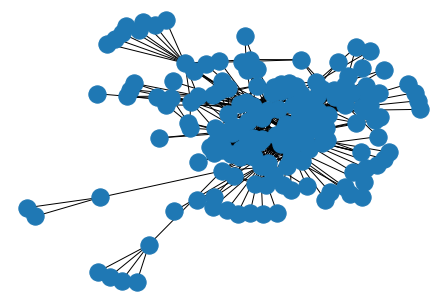

In [35]:
import matplotlib.pyplot as plt
nx.draw(G, pos=nx.spring_layout(G))
plt.draw()

In [36]:
from pyvis import network as net

In [37]:
nt = net.Network(notebook=True)
nt.from_nx(G)
nt.show('nx.html')

You can zoom in on this pyvis and start seeing connections between characters. You can also run the following code and create a sankey chart using https://rawgraphs.io/.

In [38]:
identified_names = film1_entities.explode('identified_names')
identified_names = identified_names[['Character', 'identified_names']]
spacy_names = film1_df.set_index(['Character', 'Sentence']).apply(pd.Series.explode).reset_index()
spacy_names = spacy_names[spacy_names.spacy_entities == 'PERSON'][['Character', 'spacy_tokens']]
merged_names = pd.merge(spacy_names, identified_names, on=['Character'], how='outer')
merged_names = merged_names.fillna('')
merged_names.to_csv('merged_hp_characters.csv')

![sankey](./images/sankey_characters.png)

In this graph, we can see our `Character` column from the film1_df, and then under `spacy_tokens` is the spaCy identified NER versus those we used the chars_df for under `identified_names`. We can see that there is some consistency but that we would need to either do spaCy with bigrams or do split_names in identified_names to probably clarify our results.

***

#### Additional Exercises for Wednesday

Two choices for Wednesday:

1. Keep working with Harry Potter data
2. OR start working with the new dataset below

Option 1:

For the Harry Potter dataset, here are the following steps:
- Load in the other scripts and join them with our first film
- Rerun our code for identifying characters (NER algorithm and spaCy model)
If you get through that quickly:
- Try improving our code to produce better character results (get spaCy working with bigrams)
- Try expanding our custom named entities patterns to also include locations like Hogwarts and Diagon Alley

Option 2:

In the `additional_data` folder, you'll see that there's a set of spreadsheets and text files. These datasets were pulled from the ParlaMint 2.1 database https://www.clarin.si/repository/xmlui/handle/11356/1432. 

> ParlaMint 2.1 is a multilingual set of 17 comparable corpora containing parliamentary debates mostly starting in 2015 and extending to mid-2020, with each corpus being about 20 million words in size. The sessions in the corpora are marked as belonging to the COVID-19 period (after November 1st 2019), or being "reference" (before that date).

So you're goal for these datasets is to:
- load in the data and combine the correct language text files with their corresponding metadata csvs
- try and see if you can get spaCy to identify entities (you could use the speaker name similar to characters or try using all entities)
- try working with both the English and French language data, or even load in another language option from this dataset (hint remember to load in the correct spacy model)
- try working with a Stanza if you've used spaCy previously